In [17]:
import h3
import h3pandas
import numpy as np
import pandas as pd
import pydeck as pdk
import seaborn as sns
import networkx as nx
from cflp_function import *
from shapely.geometry import Polygon
from calculate_od import *
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

In [18]:
# import os
# os.environ['USE_PYGEOS'] = '0'
# import geopandas as gpd

In [19]:
hex = pd.read_csv('./hex/hex_df2.csv')
# get_fill_color(hex, "fuzzy", "viridis")

In [20]:
# Define a layer to display on a map
# layer = pdk.Layer(
#     "H3HexagonLayer",
#     hex,
#     pickable=True,
#     # stroked=True,
#     filled=True,
#     extruded=False,
#     auto_highlight=True,
#     opacity=0.6,
#     get_hexagon="hex9",
#     get_fill_color = 'color', 
#     get_line_color=[255, 255, 255],
#     line_width_min_pixels=0.1
#     )

# # Set the viewport location
# view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Value: {fuzzy}"})
# r.to_html("layer.html")

### H3 indices and polygon geometries
We want to have a geodataframe that stores the H3 indices in study area and the polygon geometries

In [93]:
lst = gpd.read_file('./h3_list.shp')

In [94]:
idx = pd.DataFrame(index=lst.hex9)

In [95]:
idx = idx.h3.h3_to_geo_boundary()

In [96]:
idx = gpd.GeoDataFrame(idx, geometry='geometry', crs='EPSG:4326')

In [25]:
# def cell_to_shapely_polygon(h3_index):
#     """
#     A function to convert H3 index to Shapely polygons

#     """
#     # hex_center_coords = h3.h3_to_geo(h3_index)
#     coords = h3.h3_to_geo_boundary(h3_index)
#     flipped = tuple(coord[::-1] for coord in coords)
#     # center_point = Point(hex_center_coords)
#     return Polygon(flipped) #, center_point

In [26]:
# hex['geometry'] = hex['hex9'].apply(cell_to_shapely_polygon) # can change the function here
# gdf = gpd.GeoDataFrame(hex, geometry='geometry', crs=4326)

### Merge compound suitability map and H3 geometry information

In [27]:
# gdf = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

### Spatial Autocorrelation

In [113]:
w = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 2 islands with ids: 891f16c693bffff, 891f1610e8fffff.
  warnings.warn(message)


In [29]:
# w_queen.min_neighbors

0

In [30]:
# w_queen.max_neighbors

6

In [31]:
# w_queen.islands

['891f16c693bffff', '891f1610e8fffff']

In [32]:
# # view islands - those that don't have any neighbors
# ax=idx.plot(color='k', figsize=(6,6))
# idx.loc[w_queen.islands,:].plot(color='red', ax=ax)

In [33]:
# Drop the islands
# idx = idx.drop(w_queen.islands)

In [34]:
# recalculate spatial weights matrix
# w = weights.Queen.from_dataframe(idx, use_index=True)

c:\Users\User\anaconda3\envs\scip\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


In [114]:
# Row standardize the matrix
w.transform = 'R'

('WARNING: ', '891f16c693bffff', ' is an island (no neighbors)')
('WARNING: ', '891f1610e8fffff', ' is an island (no neighbors)')


In [115]:
# Reindex the compound suitability df such that its indices are ordered as the H3 list geodataframe
# hex_df = hex.set_index('hex9').reindex(idx.index)
hex_df = idx.merge(hex[['hex9','color','fuzzy']], on='hex9',how='left')

In [116]:
# Get standardised fuzzy values
hex_df['fuzzy_std'] = (hex_df['fuzzy'] - hex_df['fuzzy'].mean()) / hex_df['fuzzy'].std()

In [117]:
hex_df['lag_std'] = weights.lag_spatial(w, hex_df['fuzzy_std'])

In [118]:
hex_df['lag'] = weights.lag_spatial(w, hex_df['fuzzy'])

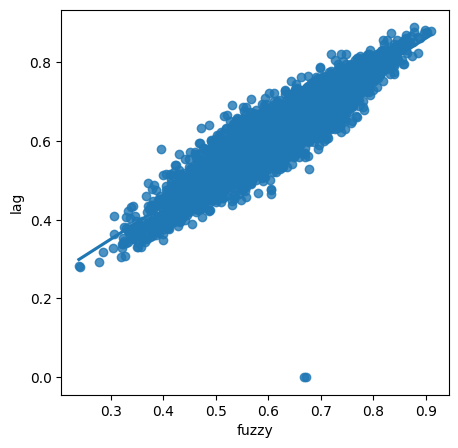

In [119]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy', y='lag', data=hex_df, ci=None)
# Add vertical and horizontal lines
# plt.axvline(0, c='k', alpha=0.5)
# plt.axhline(0, c='k', alpha=0.5)
# # plt.text(1.75, 0.5, "HH", fontsize=25)
# # plt.text(1.5, -1.5, "HL", fontsize=25)
# # plt.text(-2, 1, "LH", fontsize=25)
# # plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

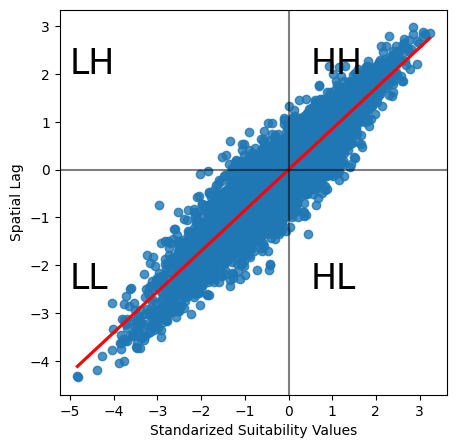

In [120]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='fuzzy_std', y='lag_std', data=hex_df, ci=None, line_kws=dict(color="r"))
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
ax.set_xlabel('Standarized Suitability Values')
plt.axhline(0, c='k', alpha=0.5)
ax.set_ylabel('Spatial Lag')
plt.text(0.5, 2, "HH", fontsize=25)
plt.text(0.5, -2.5, "HL", fontsize=25)
plt.text(-5, 2, "LH", fontsize=25)
plt.text(-5, -2.5, "LL", fontsize=25)
# Display
plt.show()

**Local Moran's I** tells you whether the local spatial pattern around each observation is similar to the overall pattern in the entire dataset.
**p_sim** is simulated p-values, which represent the probability of observing a similar or more extreme local spatial pattern under the assumption of spatial randomness.


In [121]:
lisa = esda.Moran_Local(hex_df['fuzzy'], w, seed=42)
# Break observations into significant or not
hex_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
hex_df['quadrant'] = lisa.q

In [122]:
hex_df['significant_0.01'] = lisa.p_sim < 0.01

In [123]:
np.sum(lisa.p_sim < 0.05)

4457

In [124]:
np.sum(lisa.p_sim < 0.01)

2540

In [125]:
# lisa_cluster(lisa, hex_df)

In [126]:
# plot_local_autocorrelation(lisa, hex_df, 'fuzzy')

In [127]:
# ax = hex_df.plot(color='k', figsize=(9, 9))
# hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].plot(color='red', ax=ax)
# ax.set_axis_off()

### HH Clusters to Connected Graphs

In [128]:
w

In [129]:
# pd.DataFrame(*w.full()).astype(int)

In [130]:
# Transform weight back to Binary
w.transform = 'B'

In [131]:
g = w.to_networkx()

In [132]:
print("Number of nodes:", nx.number_of_nodes(g))
print("Number of edges:", nx.number_of_edges(g))
# print("Nodes:", g.nodes())
# print("Edges:", g.edges())

Number of nodes: 11628
Number of edges: 31726


In [133]:
# NetworkX relabeled the nodes with integer starting from 0, we want the nodes to be labeled by their H3 index 
mapping = {new_index: old_index for new_index, old_index in enumerate(w.id_order)}

In [134]:
# Apply the mapping to the graph
g = nx.relabel_nodes(g, mapping)

In [135]:
# index_to_polygon = dict(zip(hex_df['hex9'], hex_df['geometry']))

In [136]:
# nx.set_node_attributes(g, index_to_polygon, 'coordinates')

In [137]:
# Get indices of H3 cells that are in the HH quadrant
HH = hex_df[(hex_df['significant'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()

In [138]:
hh = hex_df[(hex_df['significant_0.01'] == True) & (hex_df['quadrant'] == 1)].hex9.to_list()

In [139]:
print(len(HH), len(hh))

2426 1337


In [140]:
# Get sub graph that includes only the HH quadrant
H = g.subgraph(HH)

In [141]:
h = g.subgraph(hh)

In [142]:
print("Number of nodes p=0.05:", nx.number_of_nodes(H))
print("Number of nodes p=0.01:", nx.number_of_nodes(h))

Number of nodes p=0.05: 2426
Number of nodes p=0.01: 1337


In [143]:
# nx.write_graphml(g, './g.graphml')

In [144]:
# nx.write_graphml(H, './H.graphml')

In [145]:
subH = list(nx.connected_components(H))

In [146]:
subh = list(nx.connected_components(h))

In [147]:
print(len(subH), len(subh))

61 70


In [148]:
# Get connected graphs without islands (connected graphs consist of a single node)
filter_subH = [component for component in subH if len(component) > 10]
filter_subh = [component for component in subh if len(component) > 10]

In [149]:
print(len(filter_subH), len(filter_subh))

28 23


In [150]:
# Calculate eigenvector centrality for each connected component
eigenvector_centralities = []

for component in filter_subh:
    # Create a subgraph for the current connected component
    subgraph = h.subgraph(component)
    
    # Calculate eigenvector centrality for the subgraph
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    
    # Append the result to the list
    eigenvector_centralities.append(eigenvector_centrality)

In [151]:
# Print or use the list of eigenvector centralities as needed
for i, centrality in enumerate(eigenvector_centralities):
    print(f"Connected Component {i + 1}: {centrality}")

Connected Component 1: {'891f16c8927ffff': 0.1282197886667167, '891f16cd44fffff': 0.3631238192011025, '891f16cd47bffff': 0.2371647793409044, '891f16cd457ffff': 0.2821847436606185, '891f16cd683ffff': 0.048723615313620086, '891f16cd44bffff': 0.2929987437837815, '891f16cd45bffff': 0.22326798826037997, '891f16cd443ffff': 0.37898448921607675, '891f16c8937ffff': 0.046685775125850294, '891f16cd68fffff': 0.06634484971053302, '891f16cd40fffff': 0.09053453391425634, '891f16cd453ffff': 0.23705827466389603, '891f16cd41bffff': 0.1089412868928003, '891f16cd447ffff': 0.36205973456676616, '891f16cd6bbffff': 0.09948476371868742, '891f16cd687ffff': 0.1600118127296407, '891f16cd40bffff': 0.22393997351952336, '891f16cd4cbffff': 0.08867401357561057, '891f16cd6b7ffff': 0.1799717648092989, '891f16cd473ffff': 0.19667028934564718, '891f16cd6b3ffff': 0.23582474475594353}
Connected Component 2: {'891f1656c53ffff': 0.0418175569858723, '891f16568c3ffff': 0.11734962729256053, '891f165682fffff': 0.038164314022009774

In [152]:
# export for visualization in ArcGIS
eigen = hex_df[['hex9','geometry']]

In [153]:
eigen['eigen_centrality'] = np.nan

c:\Users\User\anaconda3\envs\scip\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [154]:
# Fill in eigenvector centralities into the 'eigen' column based on 'hex9'
for centrality_dict in eigenvector_centralities:
    for node_index, centrality_value in centrality_dict.items():
        # Update the 'eigen' column with the corresponding centrality value
        eigen.loc[eigen['hex9'] == node_index, 'eigen_centrality'] = centrality_value

In [155]:
eigen[~eigen['eigen_centrality'].isna()]

,hex9,geometry,eigen_centrality
48,891f165512bffff,"POLYGON ((6.68349 52.13894, 6.68377 52.13733, ...",0.058667
49,891f165513bffff,"POLYGON ((6.68065 52.14106, 6.68093 52.13946, ...",0.065396
50,891f1655123ffff,"POLYGON ((6.68548 52.14164, 6.68576 52.14004, ...",0.148798
51,891f1655133ffff,"POLYGON ((6.68264 52.14377, 6.68292 52.14216, ...",0.140106
52,891f16551abffff,"POLYGON ((6.67981 52.14589, 6.68009 52.14428, ...",0.099907
...,...,...,...
10872,891f16c6c83ffff,"POLYGON ((6.69784 52.47963, 6.69812 52.47803, ...",0.041127
10873,891f16c6c87ffff,"POLYGON ((6.70269 52.48021, 6.70297 52.47861, ...",0.083112
10875,891f16c6c97ffff,"POLYGON ((6.69984 52.48232, 6.70012 52.48072, ...",0.029431
10876,891f16c6ca3ffff,"POLYGON ((6.71039 52.47868, 6.71067 52.47708, ...",0.144959


In [156]:
site = []
for centrality_dict in eigenvector_centralities:
    max_node_index = max(centrality_dict, key=centrality_dict.get)
    site.append(max_node_index)

In [157]:
# eigen[~eigen['eigen_centrality'].isna()].to_file('./eigen.shp')

In [158]:
# sub_size = [len(c) for c in sorted(nx.connected_components(H), key=len, reverse=True)]
# sub_sizeh = [len(c) for c in sorted(nx.connected_components(h), key=len, reverse=True)]

In [159]:
# # Plotting the histogram
# plt.hist(sub_size, bins=30, edgecolor='black')
# plt.xlabel('Connected Component Size')
# plt.ylabel('Frequency')
# plt.title('Distribution of Connected Component Sizes')
# plt.show()

In [160]:
len(set(sub_size))

NameError: name 'sub_size' is not defined

In [ ]:
nH = list(H.nodes())

In [ ]:
# hex_df[hex_df['hex9'].isin(nH)].to_file('./n005.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13476\3210048485.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df[hex_df['hex9'].isin(nH)].to_file('./n005.shp')


In [ ]:
# hex_df[hex_df['hex9'].isin(list(h.nodes()))].to_file('./n001.shp')

In [ ]:
# Counter(sub_size)

In [ ]:
# Counter(sub_sizeh)

In [ ]:
# from collections import Counter
# # Use Counter to count occurrences of each value
# value_counts = Counter(sub_size)

# # Get the 10 most common values
# most_common_values = value_counts.most_common(10)

# # Display the result(f"{value}: {count}")
# print("10 most common values and their counts:")
# for value, count in most_common_values:
#     print

10 most common values and their counts:


In [161]:
def filter_site(fuzzy_df, w, g):
    # 1. Compute loca moran's I
    lisa = esda.Moran_Local(fuzzy_df['fuzzy'], w, seed=42)
    # 2. Break observations into significant or not
    fuzzy_df['significant'] = lisa.p_sim < 0.01
    # 3. Store the quadrant they belong to
    fuzzy_df['quadrant'] = lisa.q
    # Get indices of H3 cells that are in the HH quadrant
    HH = fuzzy_df[(fuzzy_df['significant'] == True) & (fuzzy_df['quadrant'] == 1)].hex9.to_list()
    # HH = fuzzy_df[(lisa.q == 1) & (lisa.p_sim < 0.01)]
    # Build sub graph that includes only the HH quadrant
    H = g.subgraph(HH)
    # Get sub components in the sub graphs
    subH = list(nx.connected_components(H))
    print(len(subH))
    filter_subH = [component for component in subH if len(component) > 10]
    print(len(filter_subH))
    # Calculate eigenvector centrality for each connected component
    site_idx = []
    for component in filter_subH:
        # Create a subgraph for the current connected component
        subgraph = H.subgraph(component)
        # Calculate eigenvector centrality for a connected graph
        eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
        # Get the node index with the highest eigenvector centrality in that connected graph
        max_node_index = max(eigenvector_centrality, key=eigenvector_centrality.get)
        # Append the node index to a list
        site_idx.append(max_node_index)
    return site_idx

In [162]:
site_idx = filter_site(hex, w, g)

269
20


In [164]:
site

['891f16cd443ffff',
 '891f165689bffff',
 '891f160b4dbffff',
 '891f16106c7ffff',
 '891f1652ecfffff',
 '891f1619933ffff',
 '891f16cca87ffff',
 '891f16cc20bffff',
 '891f1646097ffff',
 '891f161b593ffff',
 '891f16541b7ffff',
 '891f1610e63ffff',
 '891f161940bffff',
 '891f165660bffff',
 '891f16c894fffff',
 '891f160aecfffff',
 '891f160a87bffff',
 '891f16c6c2bffff',
 '891f1655cc3ffff',
 '891f16c0b13ffff',
 '891f1657497ffff',
 '891f16190b3ffff',
 '891f1611437ffff']

In [163]:
site_idx

['891f16568c7ffff',
 '891f165693bffff',
 '891f160a697ffff',
 '891f16cc263ffff',
 '891f1610a93ffff',
 '891f16ccac7ffff',
 '891f164654fffff',
 '891f161068fffff',
 '891f1655cdbffff',
 '891f1610a63ffff',
 '891f161b44bffff',
 '891f1656ac7ffff',
 '891f16c5b67ffff',
 '891f16cc297ffff',
 '891f1619483ffff',
 '891f16c8943ffff',
 '891f1656283ffff',
 '891f1654cc7ffff',
 '891f161955bffff',
 '891f16cce83ffff']

In [165]:
hex_df[hex_df['hex9'].isin(site_idx)].to_file('./site_idx.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_16312\4050862253.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df[hex_df['hex9'].isin(site_idx)].to_file('./site_idx.shp')


In [166]:
hex_df[hex_df['hex9'].isin(site)].to_file('./site.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_16312\3912182394.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_df[hex_df['hex9'].isin(site)].to_file('./site.shp')


In [167]:
set(site_idx).intersection(set(site))

set()

In [ ]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    site,
    pickable=True,
    # stroked=True,
    filled=True,
    extruded=False,
    auto_highlight=True,
    opacity=0.6,
    get_hexagon="hex9",
    get_fill_color = "color", 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=0.1
    )


# Set the viewport location
view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=9, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Count: {value}"})
r.to_html("h3_hexagon_layer_cropped_new.html")